# Overview
Use this notebook to convert an OCT image you have to an H&E image in order to evaluate how the code works.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/zero_shot_segmentation/blob/main/zero_shot_segmentation_oct.ipynb)
 and run.


# inputs

Assumptions:

oct scan x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 1

pix2pix input sizes:
*   virtual histology input width = 256
*   virtual histology input height = 256

pix2pix input x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 2

In [1]:
# Path to an OCT image to convert
oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Raw Data Used In Paper (Paper V2)/LG-19 - Slide04_Section02 (Fig 3.c)/OCTAligned.tiff"

In [2]:
import torch
import torchvision

In [3]:
visualize_oct2hist_outputs = False

FIG_SIZE = (10,5)

In [4]:
#rf
rf_api_key="R04BinsZcBZ6PsfKR2fP"
rf_workspace="yolab-kmmfx"
rf_project = "connect_from_colab"
rf_dataset = "png-mask-semantic"


In [5]:
#sam
using_colab = True
visualize_sam_outputs = True

#sam
points_per_side=32
pred_iou_thresh=0.90
stability_score_thresh=0.95
crop_n_layers=1
crop_n_points_downscale_factor=2
min_mask_region_area=3000

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [7]:
import os

# Clone repository
if not 'setup_env_oct2Hist_usemodel' in globals():
  !git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-UseModel
  %run /content/OCT2Hist-UseModel/setup_env.ipynb
  setup_env_oct2Hist_usemodel = True

Cloning into 'OCT2Hist-UseModel'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 236 (delta 47), reused 47 (delta 15), pack-reused 156
Receiving objects: 100% (236/236), 8.71 MiB | 19.86 MiB/s, done.
Resolving deltas: 100% (126/126), done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.        
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513        
Receiving objects: 100% (2513/2513), 8.20 MiB | 15.83 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'


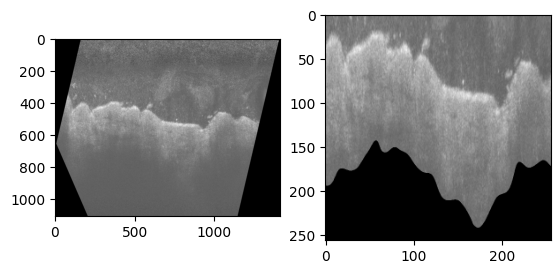

FileExistsError: ignored

FileExistsError: ignored

FileExistsError: ignored

In [12]:
%run /content/OCT2Hist-UseModel/ConvertOCTImagesToHistology.ipynb

#run sam on virtual histology

In [13]:
#util functions were taken from https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb#scrollTo=dZSU9BpHr2gc
!pip install dataclasses-json
!pip install supervision

import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 1.8 MB/s eta 0:00:00


## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [14]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=rf_api_key)
project = rf.workspace(rf_workspace).project(rf_project)
dataset = project.version(1).download(rf_dataset)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.7 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=f6642973cc909ee9937a4b982d1accee077ad39911b0de4472cb05cbebc118fa
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: idna
    Found 

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to connect_from_colab-1 in png-mask-semantic:: 100%|██████████| 6/6 [00:00<00:00, 2162.20it/s]


In [15]:
import os
DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)
print(IMAGES_DIRECTORY_PATH)
print(ANNOTATIONS_FILE_PATH)

/content/OCT2Hist-UseModel/connect_from_colab-1/test
/content/OCT2Hist-UseModel/connect_from_colab-1/test/_annotations.coco.json


In [16]:
if using_colab:
  print("PyTorch version:", torch.__version__)
  print("Torchvision version:", torchvision.__version__)
  print("CUDA is available:", torch.cuda.is_available())
  import sys
  !{sys.executable} -m pip install opencv-python matplotlib
  !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  !mkdir images
  !wget -P images https://pbs.twimg.com/media/FvpQj7UWYAAgxfo?format=jpg&name=large
#https://twitter.com/JMGardnerMD/status/1655724394805706752/photo/1
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jhwxm2go
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-jhwxm2go
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=2fcad66e2cc8e76a30e71a8917e94e4bfcd82cdc7d70bb938f675faeb3cfd9dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-p_v38f2u/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-08-18 21:04:20--  https://pbs.twimg.com/media/FvpQj7UWYAAgxfo?format=jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 72.21.91.70, 2a04:4e42:84::159
Connecting to pbs.twimg.com (pb

In [17]:
import supervision as sv

## Set-up

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [19]:
def show_anns(anns):

  if len(anns) == 0:
    return
  sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
  ax = plt.gca()
  ax.set_autoscale_on(False)

  img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
  img[:,:,3] = 0
  for ann in sorted_anns:
      m = ann['segmentation']
      color_mask = np.concatenate([np.random.random(3), [0.35]])
      img[m] = color_mask
  ax.imshow(img)

## Example image

In [20]:
%matplotlib notebook
%matplotlib inline

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(histology_image_resized)

In [ ]:
if visualize_sam_outputs:
  plt.figure(figsize=FIG_SIZE)
  plt.imshow(histology_image_resized)
  show_anns(masks)
  plt.axis('off')
  plt.show()

In [ ]:
plt.figure(figsize=FIG_SIZE)
plt.imshow(cropped)
show_anns(masks2)
plt.axis('off')
plt.show()

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

Show all the masks overlayed on the image.

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:[link text](https://)


In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=points_per_side,
    pred_iou_thresh=pred_iou_thresh,
    stability_score_thresh=stability_score_thresh,
    crop_n_layers=crop_n_layers,
    crop_n_points_downscale_factor=crop_n_points_downscale_factor,
    min_mask_region_area=min_mask_region_area,
)

In [ ]:
masks2 = mask_generator_2.generate(histology_image_resized)

In [ ]:
if visualize_sam_outputs:
  plt.figure(figsize=FIG_SIZE)
  plt.imshow(histology_image_resized)
  show_anns(masks2)
  plt.axis('off')
  plt.show()

In [ ]:
if visualize_sam_outputs:
  boolean_masks = [
      masks2['segmentation']
      for masks2
      in sorted(masks2, key=lambda x: x['area'], reverse=True)
  ]

  sv.plot_images_grid(
      images=boolean_masks,
      grid_size=(len(masks), int(len(boolean_masks) / 4)),
      size=(16, 16)
  )

#project on oct

In [ ]:
plt.figure(figsize=FIG_SIZE)
plt.imshow(cropped)
show_anns(masks2)
plt.axis('off')
plt.show()